Propeller Loaded Succesfully
Mesh Generated Succesfully
----Processing Blade 1----
-----Spanwise section----- 0
rep_idx (4, 0)
radius vector [ 0.00116753  0.01028071 -0.00434986]
r_R 0.09401884681622988
Zero-lift angle (interpolated): 0.929°
span 0 and (0, 0)
radius vector [-0.00731591  0.01028071 -0.0016355 ]
axia component -1.3231335302417466
tangential component -6.9661206317580096
control points [ 1.34268409  1.36028071 -0.0016355 ]
total_velocity_in [ 5.80860357  4.13348958 -0.        ]
total_inflow_in [ 5.43456968  4.37781785 -1.32313353]
induced [-0.3740339   0.24432827 -1.32313353]
radius vector [-0.00731591  0.01028071 -0.0016355 ]
alpha_inflow 10.754558405565358
alpha 43.10459493224527
twist 18.189995297639594
panel_force [ 0.00069316 -0.00019732  0.00219418]
cl_inv 4.726947776116244
cl_vis 0.8184075156144751
span 0 and (1, 0)
radius vector [-0.00519453  0.01028071 -0.00231253]
axia component -1.5048535387614925
tangential component -6.249348390121707
control points [ 1.34480

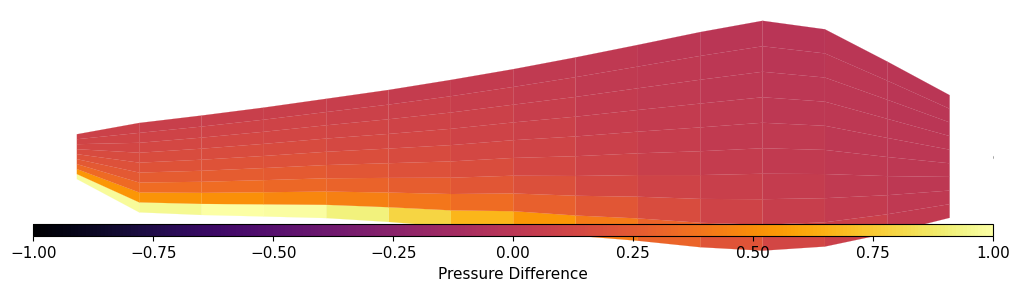

In [1]:
from propeller import PropellerGeometry
from mesh import PropellerMesh
from dynamics import SixDOFDynamics
from static import QuadcopterForceMoments
from nl_vlm import VLM
from wind import WindField
from scipy.interpolate import UnivariateSpline, LinearNDInterpolator, NearestNDInterpolator
from scipy.io import savemat
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numba as nb
import copy
import pyvista as pv



#-----------------------------------------------------------------------------------------------------------------------------------------------------------------_#
# Initializ/e geometry and mesh
propeller_geometry = PropellerGeometry(
    airfoil_distribution_file='DJI9443_airfoils.csv',
    chorddist_file='DJI9443_chorddist.csv',
    pitchdist_file='DJI9443_pitchdist.csv',
    sweepdist_file='DJI9443_sweepdist.csv',
    heightdist_file='DJI9443_heightdist.csv',
    R_tip=0.11938,
    R_hub=0.00624,
    num_blades=1
)

# Initialize and generate mesh as before
# propeller_geometry = PropellerGeometry(
#     airfoil_distribution_file='NASA_UAM_quadrotor.csv',
#     chorddist_file='NASA_UAM_quadrotor_chorddist.csv',
#     pitchdist_file='NASA_UAM_quadrotor_pitchdist.csv',
#     sweepdist_file='NASA_UAM_quadrotor_sweepdist.csv',
#     R_tip=2.809,
#     R_hub=0.3372,
#     num_blades=3
# )

propeller_mesh_system = PropellerMesh(propeller_geometry, arm_length=1.35, com=(0, 0, 0))
print('Propeller Loaded Succesfully')

quad_propeller_mesh = propeller_mesh_system.generate_quad_propeller_mesh()
print('Mesh Generated Succesfully')

# Initialize SixDOF dynamics
mass = 0.68  # kg

inertia_matrix = np.array([
    [1.0, 0, 0],
    [0, 1.0, 0],
    [0, 0, 1.0]

])  # Simple diagonal inertia matrix for example

initial_position = np.array([0, 0, 0])  # Starting position
initial_body_velocity = np.array([0, 0, 0])  # Starting velocity
initial_orientation = np.array([0, 0, 0])  # Starting roll, pitch, yaw
initial_angular_velocity = np.array([0, 0, 0])  # Starting angular rates

# Initialize the UVLM solver
uvlm_solver = VLM(quad_propeller_mesh)

wake_states = []

dynamics = SixDOFDynamics(
    mass=mass,
    inertia_matrix=inertia_matrix,
    initial_position=np.zeros(3),
    initial_velocity_body=np.zeros(3),
    initial_angles=np.zeros(3),
    initial_angular_rates=np.zeros(3)
)

time_points = []
normalized_forces = []
rho = 1.071778   
# 

mesh = pv.read(r"bp_50percent_75.vtk") 
wind_field = WindField(mesh)

rpm = 565
zerp = np.array([0, 0, 0])
com_position = np.array([300, 135, 50])
wind_func = WindField.update_wind_function(wind_field, com_position)
wind_field = np.zeros(3)

n_revs = 2
n_steps_rev = 80
n_steps = n_revs * n_steps_rev
dt = 2*np.pi / (rpm * n_steps_rev)

omega_dict = {  # Motor speed initialization
    'Propeller_1': np.array([0, 0, rpm]),
    'Propeller_2': np.array([0, 0, -rpm]),
    'Propeller_3': np.array([0, 0, -rpm]),
    'Propeller_4': np.array([0, 0, rpm])
}

for time_step in range(1, 2):

    # forces_and_moments = uvlm_solver.calculate_total_forces_and_moments(
    #     quad_propeller_mesh=quad_propeller_mesh,
    #     omega_dict=omega_dict,
    #     body_velocity=dynamics.velocity_body, 
    #     wind_field=wind_field,
    #     com_position=com_position,
    #     time_step=time_step,
    #     dt=dt,
    #     roll=dynamics.angles[0],
    #     pitch=dynamics.angles[1],
    #     yaw=dynamics.angles[2],
    #     rho=rho,
    # )

    # forces_and_moments = uvlm_solver.calculate_total_forces_and_moments(
    #             propeller_mesh=quad_propeller_mesh,
    #             dt=dt,
    #             rho=rho,
    #             time_step=time_step,
    #             body_velocity=dynamics.velocity_body, 
    #             omega=omega_dict,
    #             wind_field=wind_field,
    #             com_position=com_position,
    #             roll=dynamics.angles[0],
    #             pitch=dynamics.angles[1],
    #             yaw=dynamics.angles[2],
                
    #         )
    forces_and_moments = uvlm_solver.viscous_coupling(
        quad_propeller_mesh=quad_propeller_mesh,
        omega_dict=omega_dict,
        body_velocity=dynamics.velocity_body, 
        wind_field=wind_field,
        com_position=com_position,
        time_step=time_step,
        dt=dt,
        roll=dynamics.angles[0],
        pitch=dynamics.angles[1],
        yaw=dynamics.angles[2],
        rho=rho,
    )

                
    # print('force', forces_and_moments['Propeller_1']['force'])
    # print('momnet', forces_and_moments['Propeller_1']['moment'])

    # print("Time step:/", time_step)
   
    # # Step 2: Update mesh geometry for propeller rotation
    # SixDOFDynamics.update_mesh_transformations(
    #     propeller_mesh=quad_propeller_mesh,
    #     dynamics=dynamics,
    #     dt=dt,
    #     omega_dict=omega_dict
    # )

    # # Step 3: Update wake
    # uvlm_solver.update_wake(
    #     propeller_mesh=quad_propeller_mesh,
    #     time_step=time_step,
    #     dt=dt,
    #     body_velocity=dynamics.velocity_body,
    #     omega_dict=omega_dict
    # )
    
    # uvlm_solver.store_thrust(forces_and_moments, time_step)
    
    # uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, 
    #             "Propeller_1", azimuth=0, elevation=45)

#     fixed_radial_index = 3 
#     uvlm_solver.plot_span_gamma_distribution(quad_propeller_mesh, fixed_radial_index)


#     fixed_radial_index = 3 
#     uvlm_solver.plot_chord_gamma_distribution(quad_propeller_mesh, fixed_radial_index)
#     uvlm_solver.plot_detailed_gamma_distribution(quad_propeller_mesh)

#     # uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, 
#     #                     "Propeller_1", azimuth=0, elevation=30)

    uvlm_solver.plot_blades_pressure_top_view(
    quad_propeller_mesh,
    propeller_key="Propeller_1",
    omega=omega_dict["Propeller_1"], 
    body_velocity=initial_body_velocity,   
    rho=rho
)
# uvlm_solver.plot_wake_system(quad_propeller_mesh, uvlm_solver.wake_system, 
#                         "Propeller_1", azimuth=0, elevation=0)


# uvlm_solver.plot_thrust_history()   

